# Evaluation of the sktime SubLOF Model with Blood Glucose Data

SubLOF is the timeseries version of local outlier factor (LOF), fit to windows timeseries data.

We are evaluating the performance of the model on identifying unusual blood glucose readings (outliers) that could represent meal events. True meal events are indicated by 'ANNOUNCE_MEAL' entries in msg_type column.

## Data Loading and Preprocessing

In [10]:
import pandas as pd
import os

# load data

data_path = "../data/interim"
dataframes = []
relevant_cols = ['date', 'bgl', 'msg_type']

for filename in os.listdir(data_path):
    if filename.endswith(".csv"):
        df_day_day_name = filename.split(".")[0]
        df = pd.read_csv(
            os.path.join(data_path, filename),  
        )

        # drop irrelevant columns
        if all(col in df.columns for col in relevant_cols):
            df = df[relevant_cols]  
            df['date'] = pd.to_datetime(df['date'], errors='coerce') 
            dataframes.append(df)
        else:
            print(f"Skipping {filename} - missing required columns")

Skipping meal_annotation_plus_2hr_meal.csv - missing required columns


In [11]:
dataframes[0]

,date,bgl,msg_type
0,2024-07-01 00:00:00-05:00,98.0,NaN
1,2024-07-01 00:05:00-05:00,100.0,NaN
2,2024-07-01 00:10:00-05:00,98.0,NaN
3,2024-07-01 00:15:00-05:00,94.0,NaN
4,2024-07-01 00:20:00-05:00,94.0,NaN
...,...,...,...
26491,2024-09-30 23:35:00-05:00,95.0,NaN
26492,2024-09-30 23:40:00-05:00,87.0,NaN
26493,2024-09-30 23:45:00-05:00,86.0,NaN
26494,2024-09-30 23:50:00-05:00,89.0,NaN


In [12]:
for i in range(len(dataframes)):
    df = dataframes[i]
    df = df.dropna(subset=['bgl', 'date'])
    df = df.drop_duplicates()

    # convert ANNOUNCE_MEAL entries to flags of value 0 or 1
    df['meal_event'] = (df['msg_type'] == 'ANNOUNCE_MEAL').astype(int)
    df = df.drop(columns=['msg_type'])

    dataframes[i] = df

In [13]:
dataframes[1]

,date,bgl,meal_event
0,2024-07-01 00:00:00-04:00,115.0,0
1,2024-07-01 00:05:00-04:00,112.0,0
2,2024-07-01 00:10:00-04:00,121.0,0
3,2024-07-01 00:15:00-04:00,118.0,0
4,2024-07-01 00:20:00-04:00,115.0,0
...,...,...,...
26491,2024-09-30 23:35:00-04:00,113.0,0
26492,2024-09-30 23:40:00-04:00,112.0,0
26493,2024-09-30 23:45:00-04:00,101.0,0
26494,2024-09-30 23:50:00-04:00,96.0,0


## Fit and Predict

In [ ]:
from sktime.annotation.lof import SubLOF

# window size is set to a day: 12 * 24 = 288 five min intervals
# n_neighbors is set to 3 hours: 12 * 3 = 36 five min intervals 
# (not sure if these params are reasonable)
model = SubLOF(n_neighbors=36, window_size=288)

for i in range(len(dataframes)):
    df = dataframes[i]
    
    x = df[['bgl']]
    predicted_meal = model.fit_transform(x)
    df['predicted_meal'] = predicted_meal

    dataframes[i] = df

## Visualizing Results 

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import pytz
from matplotlib.lines import Line2D

def visualize(selected_date, df):

    df_day = df[df['date'].dt.date == pd.to_datetime(selected_date).date()]

    plt.figure(figsize=(10, 6))
    plt.plot(df_day['date'], df_day['bgl'], linestyle='-', color='b', linewidth=1)

    # plot vertical lines for meal_event == 1
    meal_events = df_day[df_day['meal_event'] == 1] 
    for date in meal_events['date']:
        plt.axvline(x=date, color='g', linestyle='--', linewidth=0.5) 

    # plot vertical lines for predicted_meal == 1
    meal_events = df_day[df_day['predicted_meal'] == 1]  
    for date in meal_events['date']:
        plt.axvline(x=date, color='r', linestyle='--', linewidth=0.5) 

    # show the time only without date
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=pytz.timezone('America/New_York')))

    # legend
    custom_lines = [Line2D([0], [0], color='g', lw=0.5, linestyle='--'),
                    Line2D([0], [0], color='r', lw=0.5, linestyle='--'),]
    plt.legend(custom_lines, ['Meal Announced by User', 'Meal Predicted'])

    plt.title(f'Blood Glucose Levels (bgl) Over Time on {selected_date}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Blood Glucose Level (bgl)', fontsize=12)

    plt.xticks(rotation=45)
    plt.show()

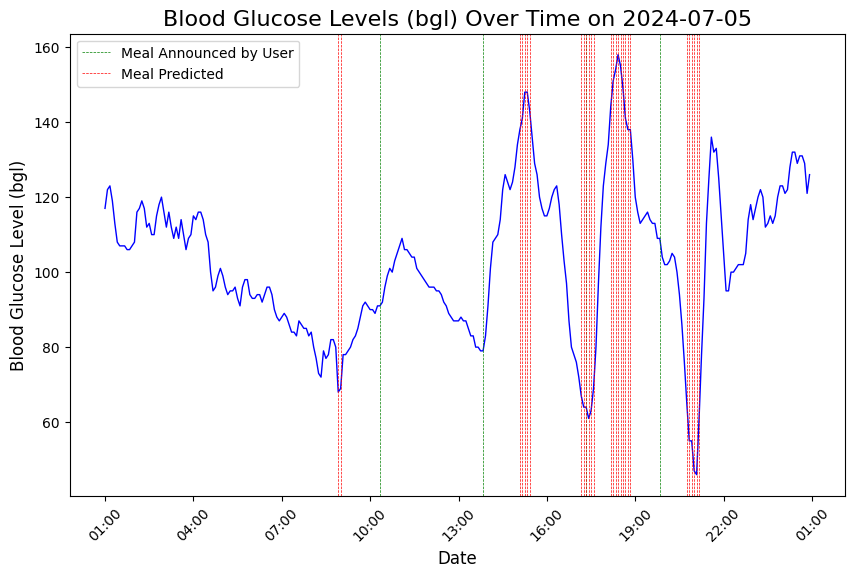

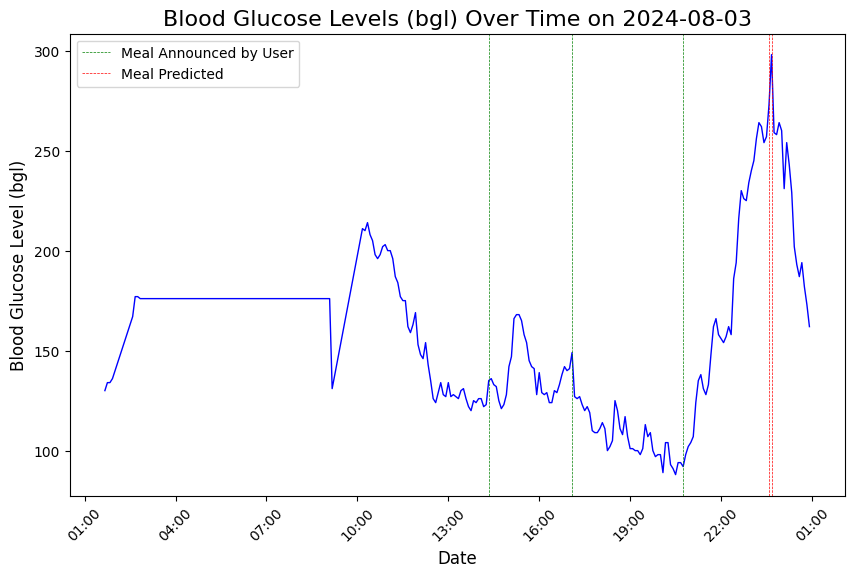

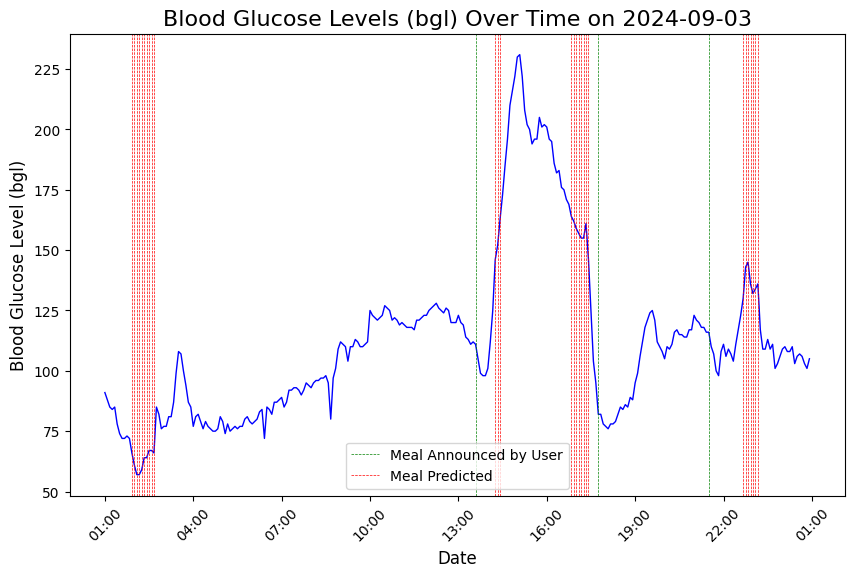

In [16]:
# selecting a day from a dataset to visualize
selected_date_1 = '2024-07-05'
selected_date_2 = '2024-08-03'
selected_date_3 = '2024-09-03'
df = dataframes[0]

visualize(selected_date_1, df)
visualize(selected_date_2, df)
visualize(selected_date_3, df)


not sure what the next steps are from here.  
the model seems to be pretty good at detecting big peaks and troughs but that doesn't necessarily correspond to meal events